In [1]:
import math
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from matplotlib.patches import Rectangle
import os
import re
from mpl_toolkits import mplot3d
from skimage.draw import polygon_perimeter
import pickle

In [2]:
class Tracking:
    def __init__(self):
        self.trajectory={}
        self.mitosis={}
        self.time_series=0
        self.H=0
        self.W=0
        self.max_label=0
#     def draw_trajectory(self):
#         if self.time_series==0:
#             return 
#         fig = plt.figure()
#         ax = plt.axes(projection='3d')
#         for key in self.trajectory.keys():
#             xline=[]
#             yline=[]
#             start=None
#             end=None
#             started=None
#             i=0
#             for tup in self.trajectory[key]:
#                 if tup[1]!=-1:
#                     started=True
#                     x1, x2, y1, y2=tup[1], tup[2], tup[3], tup[4]
#                     mid_x=(x2-x1)/2+x1
#                     mid_y=(y2-y1)/2+y1
#                     xline.append(mid_x)
#                     yline.append(mid_y)
#                 else:
#                     if start==None:
#                         start=1
#                     elif started==None:
#                         start+=1
#                     elif end==None:
#                         end=i
#                 i+=1
#             if start==None:
#                 start=0

#             if end==None:
#                 end=self.time_series

#             zline = np.linspace(start=start, stop=end, num=end+1)
#             if len(xline)!=len(zline):
#                 continue
#             ax.plot3D(xline, yline, zline, 'gray')
#         plt.show()
        
    def E_colour(self, cell_curr, cell_next):
        I_next=np.mean(cell_next)
        return math.sqrt(np.sum((cell_curr-I_next)**2)/(self.H*self.W))
    
    def E_displacement(self, cell_curr_mid_x, cell_curr_mid_y, cell_next_mid_x, cell_next_mid_y):
        return math.sqrt((cell_next_mid_x-cell_curr_mid_x)**2+(cell_next_mid_y-cell_curr_mid_y)**2)/math.sqrt(self.H**2+self.W**2)
    
    def E_skewness(self, cell_prev_x, cell_prev_y, cell_curr_x, cell_curr_y, cell_next_x, cell_next_y):
#         image_paths[self.time_series]
        tux=cell_prev_x-cell_curr_x
        tuy=cell_prev_y-cell_curr_y

        uvx=cell_curr_x-cell_next_x
        uvy=cell_curr_y-cell_next_y

        bottom=math.sqrt((tux**2+tuy**2))*math.sqrt((uvx**2+uvy**2))
        return (1-(tux*uvx+tuy*uvy)/bottom)/2

    def E_area(self, curr_x1, curr_x2, curr_y1, curr_y2, next_x1, next_x2, next_y1, next_y2):
        Su=(curr_x2-curr_x1)*(curr_y2-curr_y1)
        Sv=(next_x2-next_x1)*(next_y2-next_y1)

        if curr_y1 < next_y2 and curr_y1 > next_y1:
            if curr_x2 > next_x1 and next_x2 > curr_x2:
                overlap=(next_y2-curr_y1)*(curr_x2-next_x1)
                return (1-(overlap**2)/(Su*Sv))
            elif curr_x1 < next_x2 and curr_x1 > next_x1:
                overlap=(next_y2-curr_y1)*(next_x2-curr_x1)
                return (1-(overlap**2)/(Su*Sv))
            else:
                return 1
        elif curr_y2 > next_y1 and curr_y2 < next_y2:
            if curr_x2 > next_x1 and next_x2 > curr_x2:
                overlap=(curr_y2-next_y1)*(curr_x2-next_x1)
                return (1-(overlap**2)/(Su*Sv))
            elif curr_x1 < next_x2 and curr_x1 > next_x1:
                overlap=(curr_y2-next_y1)*(next_x2-curr_x1)
                return (1-(overlap**2)/(Su*Sv))
            else:
                return 1
        elif curr_x1==next_x1 and curr_y1==next_y1:
            return 0
        else:
            return 1
    
    def E_deformation(self, curr_x1, curr_x2, curr_y1, curr_y2, next_x1, next_x2, next_y1, next_y2):
        Au=(curr_x2-curr_x1)*(curr_y2-curr_y1)
        Av=(next_x2-next_x1)*(next_y2-next_y1)
        Pu=2*(curr_x2-curr_x1)+2*(curr_y2-curr_y1)
        Pv=2*(next_x2-next_x1)+2*(next_y2-next_y1)
        Qu=(Pu**2)/(4*math.pi*Au**2)
        Qv=(Pv**2)/(4*math.pi*Av**2)
        return abs(Qu-Qv)/math.sqrt(Qu**2+Qv**2)
    
    def E_total(self, e_col, e_dis, e_def, e_area, e_skew):
        if e_skew==None:
            return 0.33*e_col+0.33*e_dis+0.33*e_def+0.33*e_area
        return 0.2*e_col+0.2*e_dis+0.2*e_def+0.2*e_area+0.2*e_skew
    
    
    def min_E(self, path, new_img, curr_cells, next_cells):
        selected=[]
        totals=[]
        e_info=[]
        new_next_cells=next_cells.copy()
        for n_cell_info in next_cells:
            n, n_cell, n_y1, n_y2, n_x1, n_x2=n_cell_info[0], n_cell_info[1], n_cell_info[2], n_cell_info[3], n_cell_info[4], n_cell_info[5]
            n_mid_x=(n_x2-n_x1)/2+n_x1
            n_mid_y=(n_y2-n_y1)/2+n_y1

            mini=100000
            new_label=-1
            index=-1
            
            for c_cell_info in curr_cells:
                c, c_cell, c_y1, c_y2, c_x1, c_x2=c_cell_info[0], c_cell_info[1], c_cell_info[2], c_cell_info[3], c_cell_info[4], c_cell_info[5]
                c_mid_x=(c_x2-c_x1)/2+c_x1
                c_mid_y=(c_y2-c_y1)/2+c_y1
                if c_mid_x > n_mid_x+50 or c_mid_x < n_mid_x-50:
                    continue
                if c_mid_y > n_mid_y+50 or c_mid_y < n_mid_y-50:
                    continue   
                 
                if self.time_series==0:
                    e_skew=0
                else:
                    prev=self.trajectory[c][self.time_series-1]
                    prev_x1, prev_x2, prev_y1, prev_y2=prev[1], prev[2], prev[3], prev[4]
                    prev_mid_x=(prev_x2-prev_x1)/2+prev_x1
                    prev_mid_y=(prev_y2-prev_y1)/2+prev_y1
                    e_skew=self.E_skewness(prev_mid_x, prev_mid_y, c_mid_x, c_mid_y, n_mid_x, n_mid_y)
                e_colour=self.E_colour(n_cell, c_cell)
                e_dis=self.E_displacement(c_mid_x, c_mid_y, n_mid_x, n_mid_y)
                e_def=self.E_deformation(c_x1, c_x2, c_y1, c_y2, n_x1, n_x2, n_y1, n_y2)
                e_area=self.E_area(c_x1, c_x2, c_y1, c_y2, n_x1, n_x2, n_y1, n_y2)
                e_total=self.E_total(e_colour, e_dis, e_def, e_area, e_skew)
                e_info.append((n, c, e_total))

        e_info = sorted(e_info, key=lambda tup: tup[2])
        selected_n=[]
        selected_c=[]
#         print(e_info)
        for info in e_info:
            n=info[0]
            if n in selected_n:
                continue
            c=info[1]
            if c in selected_c:
                continue
            temp=list(new_next_cells[n])
            temp[0]=c
            new_next_cells[n]=tuple(temp)

            y1, y2, x1, x2=new_next_cells[n][2], new_next_cells[n][3], new_next_cells[n][4], new_next_cells[n][5]
            if c not in self.trajectory.keys():
                self.trajectory[c]=[(-1, -1, -1, -1, -1)]*self.time_series
            self.trajectory[c].append((new_next_cells[n][1], x1, x2, y1, y2))

            selected_n.append(n)
            selected_c.append(c)
#         print(len(next_cells), len(selected_n))
        for n in range(len(next_cells)):
            if n not in selected_n:
                print(n)
                self.max_label+=1
                temp=list(new_next_cells[n])
                temp[0]=self.max_label
                new_next_cells[n]=tuple(temp)
                y1, y2, x1, x2=new_next_cells[n][2], new_next_cells[n][3], new_next_cells[n][4], new_next_cells[n][5]

                if self.max_label not in self.trajectory.keys():
                    self.trajectory[self.max_label]=[(-1, -1, -1, -1, -1)]*self.time_series
                self.trajectory[self.max_label].append((new_next_cells[n][1],x1, x2, y1, y2))
        self.draw_bounding_box(new_img, new_next_cells)
        return new_next_cells

    def draw_bounding_box(self, new_img, new_next_cells):
#         print(len(new_next_cells))
        for i in range(len(new_next_cells)):
            label, cells, y1, y2, x1, x2=new_next_cells[i]
            plt.title("Number of Cells: "+str(len(new_next_cells))+"Max: "+str(self.max_label))
            plt.imshow(new_img, interpolation="nearest")
            rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')
            plt.axes().add_patch(rect) 
            plt.text(x1+1,y1+1, str(label))
        plt.show()  
#         self.draw_trajectory()
        self.time_series+=1
        return
    
    def draw_mitosis(self, img_path):
        path=img_path.split("/")
        path="/".join(path[1:])
        image_names=sorted(os.listdir(img_path))
        i=0
        for name in image_names:
            if name.endswith(".npy"):
                continue
                
            if not os.path.isdir("mitosis/"+path):
                os.makedirs("mitosis/"+path)
    
            if i not in self.mitosis:
                img=cv2.imread(img_path + name, 0)
                dim = (500, 500)
                img = cv2.resize(img, dim)
                plt.imshow(img, interpolation="nearest")
                for key in self.trajectory:
                    x1, x2, y1, y2=self.trajectory[key][i][1], self.trajectory[key][i][2], self.trajectory[key][i][3], self.trajectory[key][i][4]
                    if(x1==-1):
                        continue
                    rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')
                    plt.axes().add_patch(rect)
#                     plt.text(x1+1,y1+1, str(key))
                plt.gca().set_axis_off()
                plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
                plt.margins(0,0)
                plt.savefig("mitosis/"+path+name,bbox_inches='tight', pad_inches=0.0)
                plt.show()
                i+=1
                continue
            
            img=cv2.imread(img_path + name, 0)
            dim = (500, 500)
            img = cv2.resize(img, dim)
            for key in self.trajectory:
                if key in self.mitosis[i]:
                    continue
                plt.imshow(img, interpolation="nearest")
                x1, x2, y1, y2=self.trajectory[key][i][1], self.trajectory[key][i][2], self.trajectory[key][i][3], self.trajectory[key][i][4]
                rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')
                plt.axes().add_patch(rect)
#                 plt.text(x1+1,y1+1, str(key))
            for key in self.mitosis[i]:
                x1, x2, y1, y2=self.trajectory[key][i][1], self.trajectory[key][i][2], self.trajectory[key][i][3], self.trajectory[key][i][4]
                rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='yellow')
                plt.axes().add_patch(rect)
#                 plt.text(x1+1,y1+1, str(key))
                
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.savefig("mitosis/"+path+name,bbox_inches='tight', pad_inches=0.0)
            plt.show()
            i+=1
    
    def recover_trajectory(self):
        for t in self.trajectory:
            diff=self.time_series-len(self.trajectory[t])
            temp=[(-1, -1, -1, -1, -1)]*diff
            self.trajectory[t].extend(temp)
        how_many=0
        def find_BC(k, n, mid_x, mid_y):
            next_=n+1
            next_next=n+2
            B=[]
            C=[]
            b_key=[]
            c_key=[]
            for key in self.trajectory.keys():
                if key==k:
                    continue
#                     
                if  self.trajectory[key][n][1]!=-1 and self.trajectory[key][next_][1]!=-1:
                    x1, x2, y1, y2=self.trajectory[key][n+1][1], self.trajectory[key][n+1][2], self.trajectory[key][n+1][3], self.trajectory[key][n+1][4]
                    next_mid_x=(x2-x1)/2+x1
                    next_mid_y=(y2-y1)/2+y1
                    if next_mid_x < mid_x-50 or next_mid_x > mid_x+50:
                        continue
                    if next_mid_y < mid_y-50 or next_mid_y > mid_y+50:
                        continue
                    if self.trajectory[key][next_next][1]!=-1:
                        B.append(self.trajectory[key])
                        b_key.append(key)
                    else:
                        C.append(self.trajectory[key])
                        c_key.append(key)
            return (B, C, b_key, c_key)
            
            
        for key in self.trajectory.keys():
            arr = self.trajectory[key]
            exists=0
            n=len(arr)-1
            candidateB=[]
            candidateC=[]
            comp_info_b=[]
            comp_info_c=[]
            while n>=0:
                if arr[n][1]!=-1: 
                    if exists==0:
                        exists=1
                elif exists==1 and arr[n][1]==-1:
                    x1, x2, y1, y2=arr[n+1][1], arr[n+1][2], arr[n+1][3], arr[n+1][4]
                    mid_x=(x2-x1)/2+x1
                    mid_y=(y2-y1)/2+y1
                    if n+2 > len(arr)-1:
                        n-=1
                        continue
                    (candidateB, candidateC, b_key, c_key)=find_BC(key, n, mid_x, mid_y)

                    exists=0
                    break
                n-=1
            if exists==1:
                continue

            a_x1, a_x2, a_y1, a_y2=arr[n+1][1], arr[n+1][2], arr[n+1][3], arr[n+1][4]
            a_mid_x=(a_x2-a_x1)/2+a_x1
            a_mid_y=(a_y2-a_y1)/2+a_y1
            if len(candidateC)!=0:
                for c_C in candidateC: 
                    c_x1, c_x2, c_y1, c_y2=c_C[n+1][1], c_C[n+1][2], c_C[n+1][3], c_C[n+1][4]
                    c_mid_x=(c_x2-c_x1)/2+c_x1
                    c_mid_y=(c_y2-c_y1)/2+c_y1
                    e_colour=self.E_colour(arr[n][0], c_C[n][1])
                    e_dis=self.E_displacement(a_mid_x, a_mid_y, c_mid_x, c_mid_y)
                    e_def=self.E_deformation(a_x1, a_x2, a_y1, a_y2, c_x1, c_x2, c_y1, c_y2)
                    e_area=self.E_area(a_x1, a_x2, a_y1, a_y2, c_x1, c_x2, c_y1, c_y2)
                    e_total=self.E_total(e_colour, e_dis, e_def, e_area, None)
                    comp_info_c.append(e_dis)
                best_c_C = candidateC[comp_info_c.index(min(comp_info_c))]
                # calculate cost
            if len(candidateB)!=0:
                for b_B in candidateB: 
                    b_x1, b_x2, b_y1, b_y2=b_B[n+1][1], b_B[n+1][2], b_B[n+1][3], b_B[n+1][4]
                    b_mid_x=(b_x2-b_x1)/2+b_x1
                    b_mid_y=(b_y2-b_y1)/2+b_y1
                    e_colour=self.E_colour(arr[n][0], b_B[n][1])
                    e_dis=self.E_displacement(a_mid_x, a_mid_y, b_mid_x, b_mid_y)
                    e_def=self.E_deformation(a_x1, a_x2, a_y1, a_y2, b_x1, b_x2, b_y1, b_y2)
                    e_area=self.E_area(a_x1, a_x2, a_y1, a_y2, b_x1, b_x2, b_y1, b_y2)
                    e_total=self.E_total(e_colour, e_dis, e_def, e_area, None)
                    comp_info_b.append(e_dis)
                best_b_B = candidateB[comp_info_b.index(min(comp_info_b))]

            if len(candidateC)==0 and len(candidateB)==0:
                continue
            
            elif len(candidateC)==0:
                if n not in self.mitosis:
                    self.mitosis[n]=[]
                self.mitosis[n].append(b_key[comp_info_b.index(min(comp_info_b))])
                continue
                
            elif len(candidateB)==0:
                key_update = c_key[comp_info_c.index(min(comp_info_c))]
                how_many+=1
#                 for i in (n+1,self.time_series-1):
#                     self.trajectory[key_update][i] = arr[i]
                continue
                
            if min(comp_info_b) > min(comp_info_c) :
                key_update = c_key[comp_info_c.index(min(comp_info_c))]
                how_many+=1
#                 print("update:", key, key_update)
#                 for i in (n+1,self.time_series-1):
#                     print(i)
#                     print(len(self.trajectory[key_update]), len(arr))
#                     self.trajectory[key_update][i] = arr[i]
            else:
                if n not in self.mitosis:
                    self.mitosis[n]=[]
                self.mitosis[n].append(b_key[comp_info_b.index(min(comp_info_b))])
        return self.mitosis
    
    def tracking(self, image_path, info_path):
        image_names=sorted(os.listdir(image_path))
        curr_cells=None
        for path in image_names:
            if path.endswith(".npy"):
                continue
            img=cv2.imread(image_path + path, 0)
            dim = (500, 500)
            img = cv2.resize(img, dim)
            self.H, self.W=img.shape
            info=np.load(info_path+path.split('.')[0]+'.npy', allow_pickle=True)
            print(path.split('.')[0]+'.npy', path)
            if isinstance(curr_cells, type(None)):
                curr_cells=info
                for cell in curr_cells:
                    label, cropped, y1, y2, x1, x2 = cell[0], cell[1], cell[2], cell[3], cell[4], cell[5]
                    self.trajectory[label]=[]
                    self.trajectory[label].append((cropped, x1, x2, y1, y2))
                    self.max_label=label
                self.draw_bounding_box(img, curr_cells)
                continue
            next_cells=info
            curr_cells=self.min_E(path, img, curr_cells, next_cells)


t000.npy t000.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


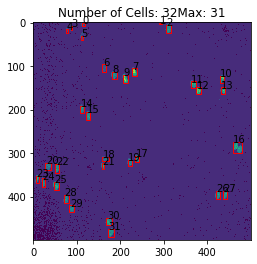

t001.npy t001.tif


/Users/shizukahayashi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


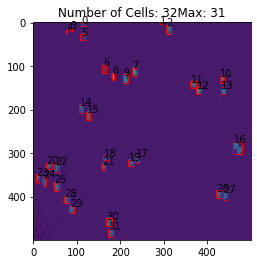

t002.npy t002.tif
11


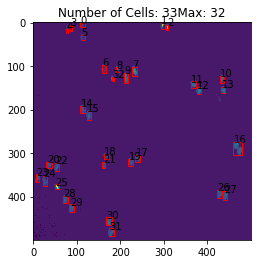

t003.npy t003.tif
15
19
33


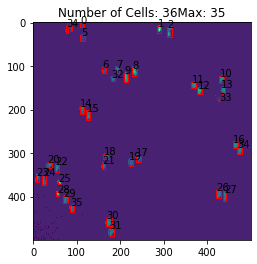

t004.npy t004.tif
6
7
14
36


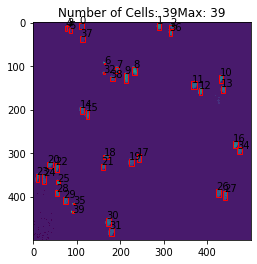

t005.npy t005.tif


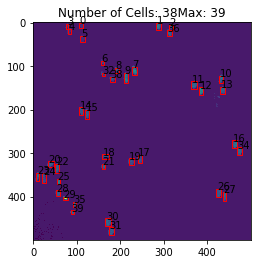

t006.npy t006.tif
17
18
38


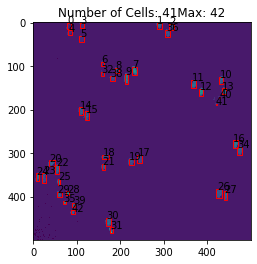

t007.npy t007.tif
39


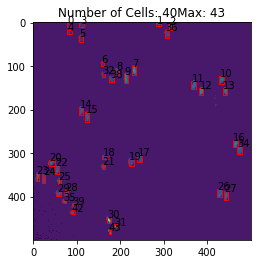

t008.npy t008.tif
40


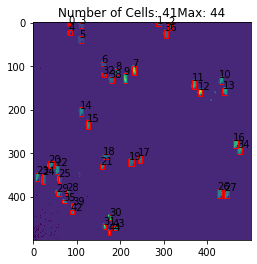

t009.npy t009.tif


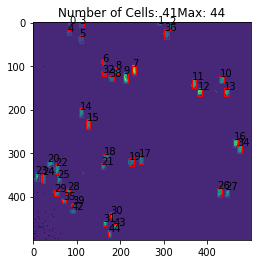

t010.npy t010.tif


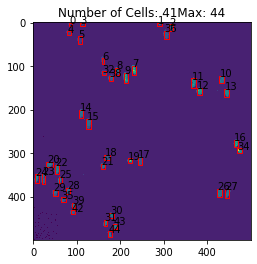

t011.npy t011.tif
21
22
29


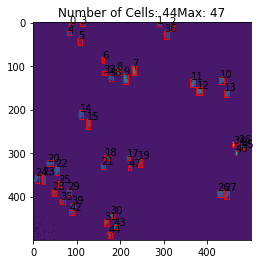

t012.npy t012.tif


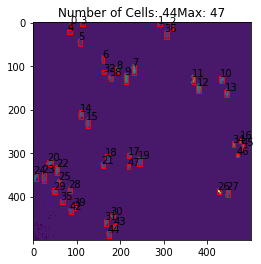

t013.npy t013.tif
16
38


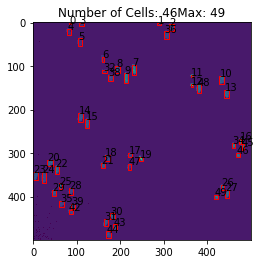

t014.npy t014.tif
30
40


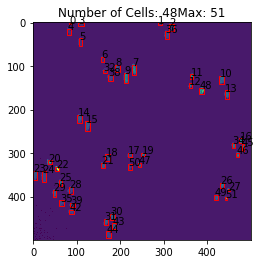

t015.npy t015.tif
17
44
45


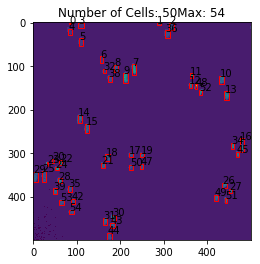

t016.npy t016.tif
23


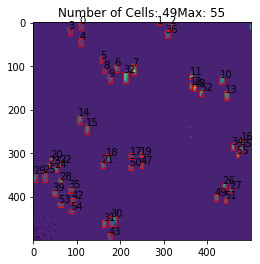

t017.npy t017.tif


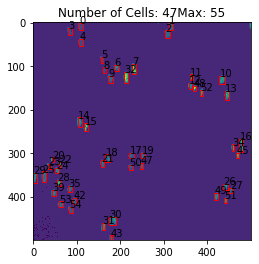

t018.npy t018.tif
1
21


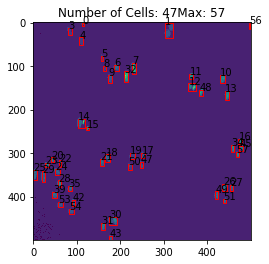

t019.npy t019.tif
13
17
46


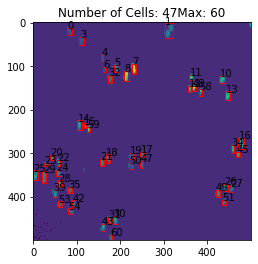

t020.npy t020.tif
1
11


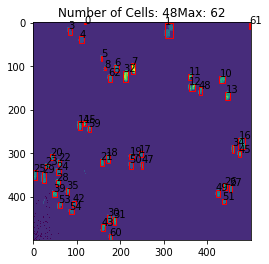

t021.npy t021.tif
12
16


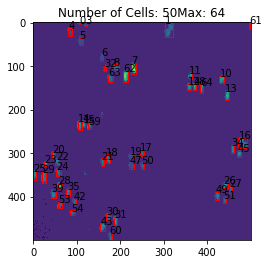

t022.npy t022.tif
24
46


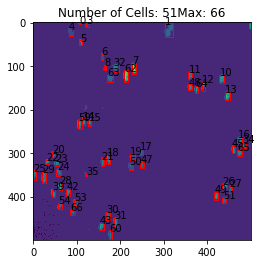

t023.npy t023.tif
5


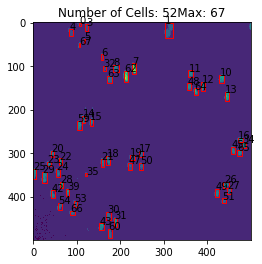

t024.npy t024.tif
1


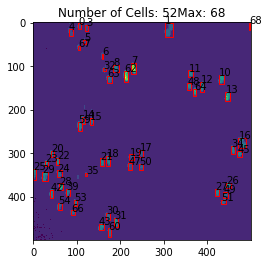

t025.npy t025.tif
48


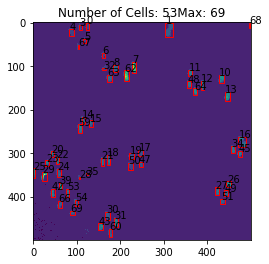

t026.npy t026.tif
49


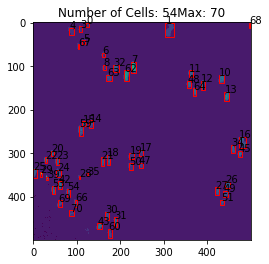

t027.npy t027.tif


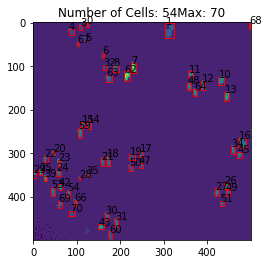

t028.npy t028.tif
53


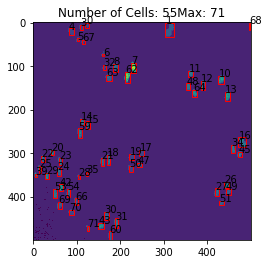

t029.npy t029.tif


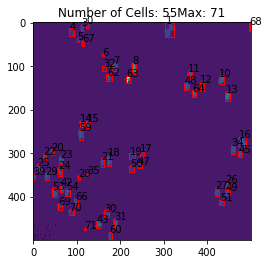

t030.npy t030.tif
53


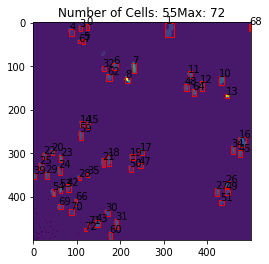

t031.npy t031.tif
14
15
20


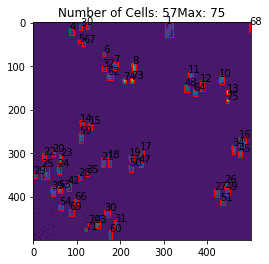

t032.npy t032.tif


In [ ]:
files=['./fluo/Sequence 1/', './fluo/Sequence 2/', './fluo/Sequence 3/', './fluo/Sequence 4/', './phc/Sequence 1/', './phc/Sequence 2/', './phc/Sequence 3/', './phc/Sequence 4/']
for file in files:
    path=file.split("/")
    path="/".join(path[1:])
    task1=Tracking()
    task1.tracking(file, file)
    mitosis=task1.recover_trajectory()
    task1.draw_mitosis(file)
    if not os.path.isdir("mitosis/"+path):
        os.makedirs("mitosis/"+path)
        
    with open('mitosis/'+path+'trajectory.pkl', 'wb') as f:
        pickle.dump(task1.trajectory, f, pickle.HIGHEST_PROTOCOL)
        
    with open('mitosis/'+path+'mitosis.pkl', 'wb') as f:
        pickle.dump(mitosis, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
print(mitosis)

In [ ]:
# print(mitosis)

In [ ]:
# for t in task1.trajectory:
#     diff=task1.time_series-len(task1.trajectory[t])-1
#     arr=[(-1, -1, -1, -1, -1)]*diff
#     task1.trajectory[t].extend(arr)

In [ ]:
# task1.trajectory[2][1]

In [ ]:
# exists=0
# arr=task1.trajectory[2]
# n=len(arr)-1
# while n>=0:
#     print(arr[n][1])
#     if arr[n][1]!=-1: 
#         print("WTF")
#         if exists==0:
#             exists=1
#         else:
#             print("????")
#             x1, x2, y1, y2=arr[n][1], arr[n][2], arr[n][3], arr[n][4]
#             mid_x=(x2-x1)/2+x1
#             mid_y=(y2-y1)/2+y1
#             if n+2 > len(arr)-1:
#                 continue
#             (candidateB, candidateC)=find_BC(n, mid_x, y)
#     n-=1

In [ ]:
# a[0][1]

In [ ]:
# task1.trajectory[2]

In [ ]:
# task1.mitosis

In [ ]:
# image_names=sorted(os.listdir("./fluo/Sequence 1/"))

In [ ]:
# image_names

In [ ]:
# with open('mitosis.pkl', 'wb') as f:
#         pickle.dump(mitosis, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('trajectory.pkl', 'rb') as f:
#     trajectory=pickle.load(f)

In [ ]:
# trajectory[0][0]